# Introduction and background

## Overview

We performed a predictive analysis on data from Kickstarter to see which factors are more correlated with the succes and failure of a Kickstarter project, and see if we can extraploate those correlations to predict which kind of Kickstarter projects are more likely to be successful.
(Professor indicates overview should be withn 3-4 sentences)

## Names

- Alan Lloyd Willey
- Enlin Wei
- Kanami Hannah Tanaka
- Karen Rodriguez Pinto
- Yumi Minami
- Yuxiao Fan

## Group Members IDs

- A15746309
- A12669124
- A14714448
- A15161856
- A12938737
- A14778609

## Research Question

We are conducting this research to investigate what could be most predictive of a Kickstarter project's outcome, so the research question we wanted to ask for this project was "Among the US-based Kickstarters, which factor (within the information given in the dataset) contributes most to a Kickstarter's outcome?"


## Background and Prior Work

Before we introduce Kickstarter, we will take a look at crowdfunding platforms, which is what Kickstarter is. Basically, crowdfunding platforms allow those with innovative projects to pitch those projects to the public with a goal of a certain amount of money to raise; and if people like that idea and would like to support it, they can donate funds to help

A crowdfunding platforms like Kickstarter allows users to raise money and typically provide backer rewards or pre-order products. For example a filmmaker may offer a digital copy film, a live viewing of premier, signed posters, etc. A tech company could be offering pre-orders of their new phone cases or other product.

Kickstarter is a crowdfunding platform which was created by Perry Chen and Yancy Strickler in 2009, to be a place where the main focus is not Kickstarter's profit but success for those who pitch their projects. If a project raises enough money to meet its goal, it will receive those funds, and Kickstarter makes money from a 3-5% fee taken from the funds. Kickstarter does make efforts to ensure you keep your promises to backers and fraud charges could be made if you can't deliver or use funds improperly. Because funds from backers to creators cannot be charged unless the project reaches their goals, we consider this website is based on the perspectives of all-or-nothing.

References (include links):
- 1) "Kickstarter crowdfunding site officially launches in Canada". The Canadian Press. 10 September 2013. Retrieved 8 June 2019. https://www.cbc.ca/news/business/kickstarter-crowdfunding-site-officially-launches-in-canada-1.1703774
- 2) Isaac, Mike and David Gelles (September 21, 2015). "Kickstarter Focuses Its Mission on Altruism Over Profit". The New York Times. https://www.nytimes.com/2015/09/21/technology/kickstarters-altruistic-vision-profits-as-the-means-not-the-mission.html

## Hypothesis


(hypothesis should be clear and short for grader to view)
we assmue main_category would have the most influencial facotor to decide the failure or success of the project. More specifically, we assume main_categry of ‘music’, ‘film and video’, and ‘publishing’ have the highest probability of success since those categories are easier to be promoted through funding promotions.

origin:
{Our hypothesis for this kickstarter dataset is that there were many factors that could involve in making one kickstarter funding project become successful or not, for example, the backers’  own interests towards certain categories, how much value that the project has to put some fundings in from the perspective of backers, how much backers are wealthy at the time when the project created, the occurrence of economic impacts which could have effects on backers’ funding minds, etc.

Specifically speaking, we assumed that the main categories which possibly have strong influences on funding and become successful are ‘music’, ‘film and video’, and ‘publishing’ because those categories are easier to be promoted through funding promotions. Those categories are quite all rounders, which means that are quite inclusive to any age group, gender, or so on. Also, if the producer possibly have followers on their artistic work, it could make easier for them to acquire help for funding. Also, there could not any possible harms which be led from those products to backers, so psychologically speaking, it could be quite easier to be funded for them. Interestingly, we also assumed that the categories that failed easier could be the same categories which we assumed as the successful ones, because their funding is based on backers’ interests and preferences. In order to succeed in funding, the projects have to consider the backers’ popular and public trends; if one project was focused on one specific group of people, then it has a higher chance to fail.

delete this hypothesis if we don't answer it in conclusion:

Additionally, the interesting factor that we assumed could have influences is the name length of each project. It is because the longer name could be seen quite professional so that it can be felt pressured to backers. If one project name is too long to read at once and too hard to figure out what the project is, then we hypothesized that it could be hard to be funded form backers. On the other hand, we are not saying ‘the shorter the name is, the better’. The name could be short enough for backers or funders to tell what the project is about, however it has to contain descriptions clear enough as well.}

## Dataset(s)

- Dataset Name: Kickstarter Campaigns
- Link to the dataset: https://www.kaggle.com/yashkantharia/kickstarter-campaigns
- Number of observations: 192548

This dataset contains information about Kickstarter crowdfunding campaigns from 2014 to February 2019. The information includes the names, currency, main and subcategories, launch date and deadlines, goal amount of money to raise and actual amounts raised, whether the campaign was successful or failed, and geographical locations of the campaigns (country and state).

We found this dataset is interesting because of the following reasons:
- Kickstarter funding have done by creators and backers, and they are not based on profits consideration for each other; backers do the funding for creators if they think their projects seemed successful or beneficial.
- We can observe the data while considering the reasons why one projects went successful on funding but the other did not; There should be some factors having a correlation with successful ones and failed ones. 
- This dataset has quite a lot of columns that we could make many researches, although we are not going through all of the possible research.

# Data Analysis

## Data Cleaning & Pre-processing

In [106]:
# imports
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [58]:
# loads Kickstarters data into dataframe
df_kickstarters = pd.read_csv("Kickstarter_projects_Feb19.csv")

In [59]:
# viewing the first rows of the dataframe
df_kickstarters.head()

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1687733153,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.00000,Menasha,WI,US,14,7,successful,10,11,Q4,Q4,6061.00000
1,227936657,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,2018-08-06 10:00:43,2018-09-05 10:00:43,30.0,3870.99771,Shepperton,England,GB,24,8,successful,8,9,Q3,Q3,3914.50512
2,454186436,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.00000,Manhattan,NY,US,21,7,successful,6,7,Q2,Q3,1110.00000
3,629469071,Lost Dog Street Band's Next Album,USD,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.00000,Nashville,TN,US,15,6,successful,9,11,Q3,Q4,4807.00000
4,183973060,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.00000,Troy,MI,US,15,4,successful,11,1,Q4,Q1,40368.00000


We decided to add a column with the difference in goal_usd and usd_pledged.

In [60]:
df_kickstarters = df_kickstarters.assign(goal_minus_pledge = df_kickstarters['goal_usd'] - df_kickstarters['usd_pledged'])

We will first take the subset of US-based kickstarters only, since other countries may have different opinions on the kinds of projects they like and that could introduce confounding variations in our analysis. So we'll use country as a control and drop projects that are not US-based.

In [61]:
df_kickstarters = df_kickstarters[df_kickstarters['country']=='US']

We checked to see that the country and the currency are both US-only after the drop.

In [62]:
df_kickstarters.country.unique()

array(['US'], dtype=object)

In [63]:
df_kickstarters.currency.unique()

array(['USD'], dtype=object)

We then checked to see if any cell has null values, and if so to drop those entries.

In [64]:
df_kickstarters[df_kickstarters.isnull().any(axis=1)]

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,...,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged,goal_minus_pledge


We checked the unique states.

In [65]:
df_kickstarters['state'].unique()

array(['WI', 'NY', 'TN', 'MI', 'WA', 'CA', 'IL', 'CT', 'OK', 'VA', 'AZ',
       'MN', 'TX', 'PA', 'RI', 'MO', 'IA', 'MA', 'OH', 'CO', 'Kabul', 'FL',
       'AK', 'MD', 'KS', 'NJ', 'LA', 'Istanbul', 'SC', 'HI', 'Vienna',
       'IN', 'San Juan', 'NC', 'WV', 'DC', 'NE', 'UT', 'Central', 'MS',
       'VT', 'GA', 'OR', 'AR', 'ME', 'Auvergne', 'Phnum Penh', 'SD', 'MT',
       'AL', 'KY', 'ND', 'NV', 'Gaza', 'Shanghai', 'Siem Reap Province',
       'Udmurtia Republic', 'Tuscany', 'ID', 'England', 'ON',
       'DKI Jakarta', 'WY', 'NM', 'Seoul', 'NH', 'South Bohemian Region',
       'Rajasthan', 'Santiago Metropolitan Region', 'Saitama Prefecture',
       'Tokyo Prefecture', 'Shiga Prefecture', 'Central Kalimantan',
       'Ã\x98Â³Ã\x99Â\x88Ã\x98Â³ Ã\x99Â\x80 Ã\x99Â\x85Ã\x98Â§Ã\x98Â³Ã\x98Â© Ã\x99Â\x80 Ã\x98Â¯Ã\x98Â±Ã\x98Â¹Ã\x98Â©',
       'Pirkanmaa', 'Sud', 'Beirut', 'West Bengal', 'BC', 'Satakunta',
       'Limburg', 'Ulaanbaatar', 'Thessaly and Continental Greece',
       'Splitsko-Dalmati

There are still many entries that are NOT US states, so we will clean that up so it only contains US states.

In [66]:
def check_state(state_abbrv):
    lst_states = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UM', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']
    if state_abbrv in lst_states:
        return state_abbrv
    else:
        return 'X'

In [67]:
df_kickstarters['state'] = df_kickstarters['state'].apply(check_state)

In [68]:
df_kickstarters = df_kickstarters[df_kickstarters['state']!='X']

In [69]:
# checking to see only 50 states
len(df_kickstarters['state'].unique())

50

We found no null values in the dataset, and so we proceeded with data cleaning.

We first dropped the column 'id' since it gives no useful information, just an ID associated with the project. We then dropped columns 'start_month' and 'end_month' since the information about the start and end months of the projects are already given in the dates in the 'launched_at' and 'deadline' columns and so is redundant. We checked to see that the country and currency are all US-based, so it would not be necessary to keep those columns.

In [70]:
df_kickstarters.drop(columns=['id', 'country', 'currency'], inplace=True)

Finally, we noticed some of the monetary amounts have more than 2 decimal places, which should be cleaned up since we don't work with monetary amounts more specific than 2 decimal places. So we decided to round the amounts to 2 decimal places.

In [71]:
df_kickstarters['goal_usd'] = df_kickstarters['goal_usd'].round(2)
df_kickstarters['usd_pledged'] = df_kickstarters['usd_pledged'].round(2)

## Data visualization

Since our project aims to analyze which factor is most important for the success of kickstarters, we will divide the dataframe into two separate ones, one with all the successful projects and one with all the failed projects.

In [72]:
# divides df_kickstarters into successful and failed ones
df_successful = df_kickstarters[df_kickstarters['status']=='successful']
df_failed = df_kickstarters[df_kickstarters['status']=='failed']

We next plotted the categories to see which ones are more likely to be successful.

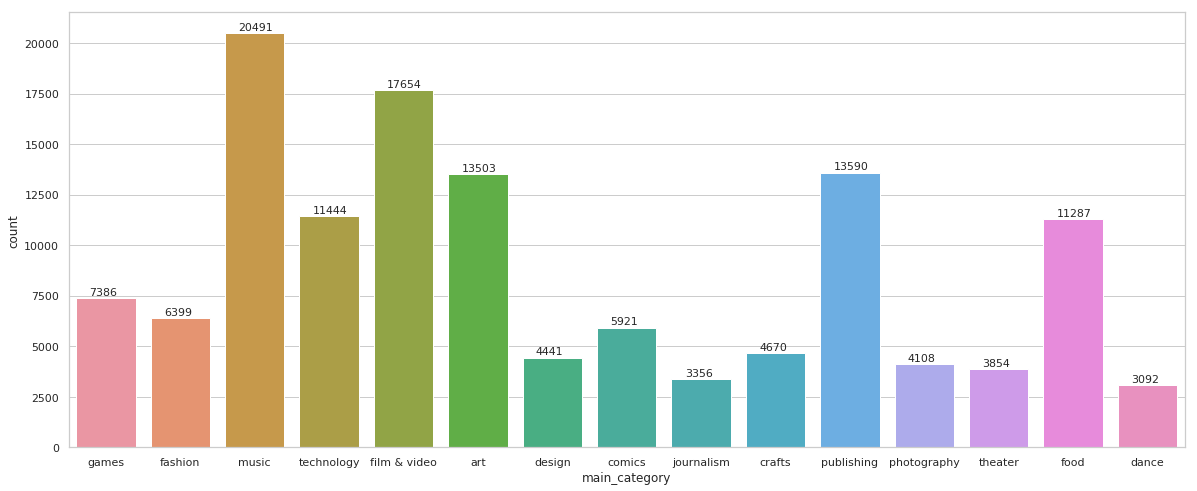

In [73]:
#plot histogram of the amount of projects among all the main_category
plt.figure(figsize=(20,8))
axPlt = sns.countplot(x='main_category',data=df_kickstarters)

for i in axPlt.patches:
    # get_x pulls left or right; get_height pushes up or down
    axPlt.text(i.get_x()+.18, i.get_height()+150, \
            str(round((i.get_height()), 2)), fontsize=11)

Grouping by status:

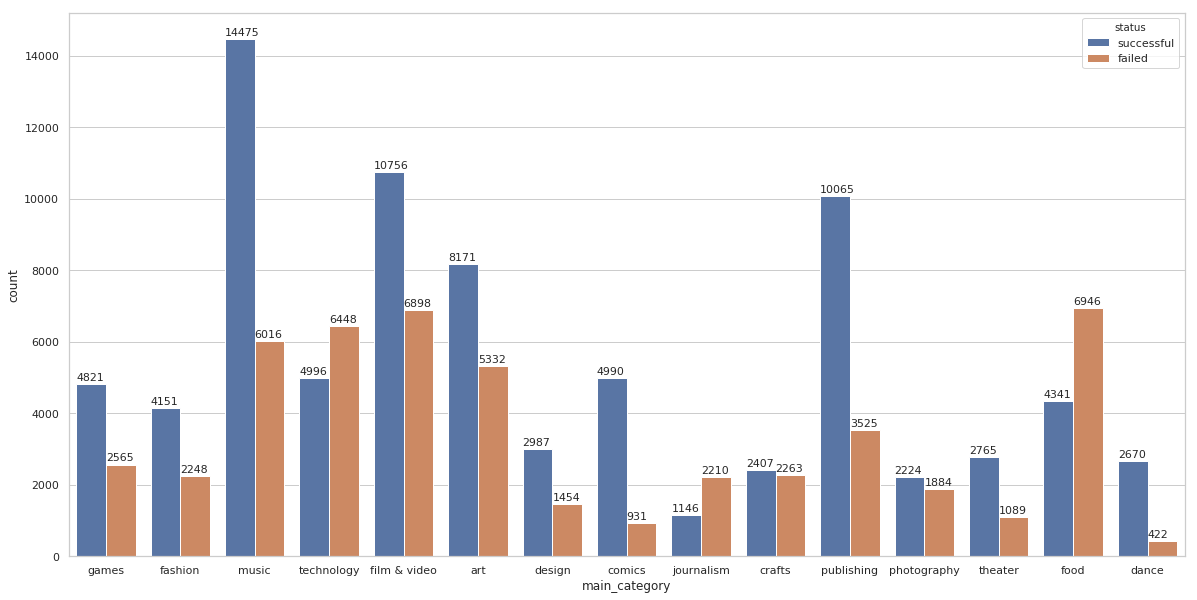

In [74]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='main_category',hue='status',data=df_kickstarters)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+100, \
            str(round((i.get_height()), 2)), fontsize=11)

It seems that there are unequal numbers of successful and failed projects; to confirm we'll take a look at how many successful and failed kickstarters there are.

In [75]:
# views number of successful and failed kickstarters
print("Number of successful kickstarters: " + str(len(df_successful))); print("Number of failed kickstarters: " + str(len(df_failed)))

Number of successful kickstarters: 80965
Number of failed kickstarters: 50231


It seems that there are different numbers of successful and failed kickstarters; we will account for that by comparing the ratio of each category in the successful versus failed kickstarters.

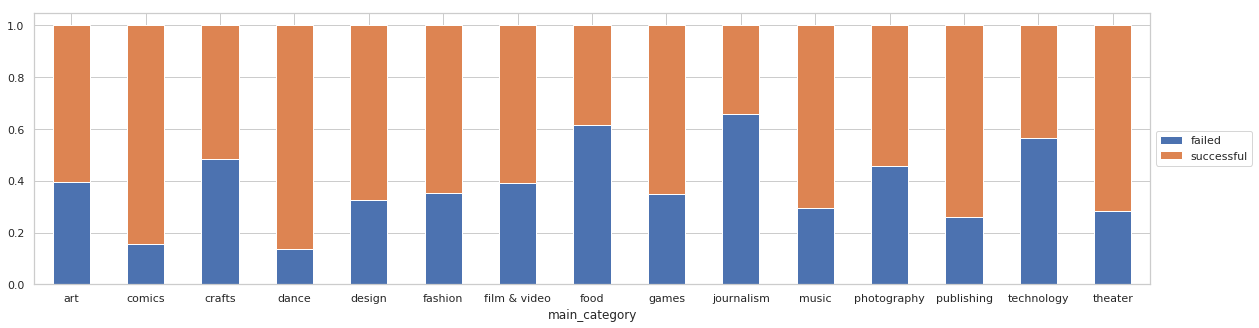

In [76]:
df_categories = df_kickstarters.groupby(['status','main_category'])['status'].count().unstack('main_category').fillna(0)
sub_df_categories = np.transpose(df_categories.div(df_categories.sum()))
sub_df_categories.plot(kind='bar',stacked=True,rot=0, figsize=(20,5))

plt.legend(('failed','successful'), loc='center left', bbox_to_anchor=(1.0, 0.5))

Next we tried visualizing all the numerical data to see their distributions.

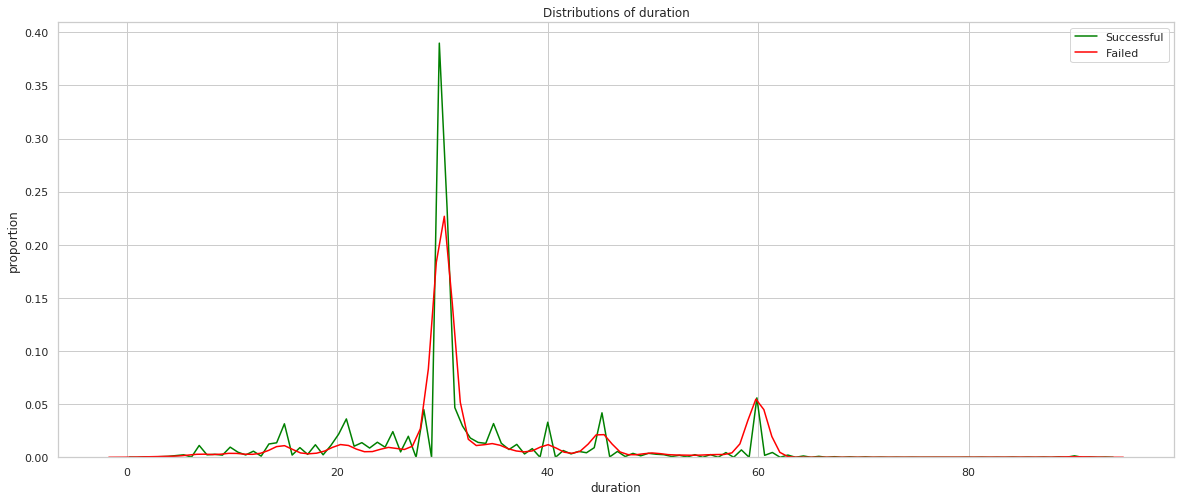

In [77]:
#distribution of duration
plt.figure(figsize=(20,8))
plt.title('Distributions of duration')
plt.ylabel('proportion')

sns.distplot(df_successful['duration'],label='Successful',color='green',hist=False)
sns.distplot(df_failed['duration'],label='Failed',color='red',hist=False)

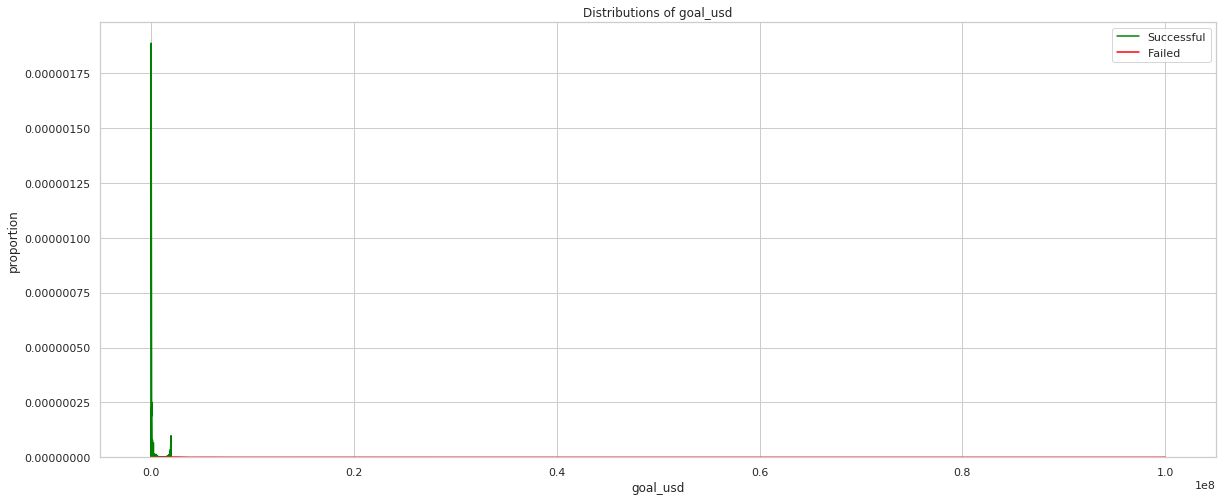

In [78]:
#distribution of goal_usd
plt.figure(figsize=(20,8))
plt.title('Distributions of goal_usd')
plt.ylabel('proportion')

sns.distplot(df_successful['goal_usd'],label='Successful',color='green',hist=False)
sns.distplot(df_failed['goal_usd'],label='Failed',color='red',hist=False)

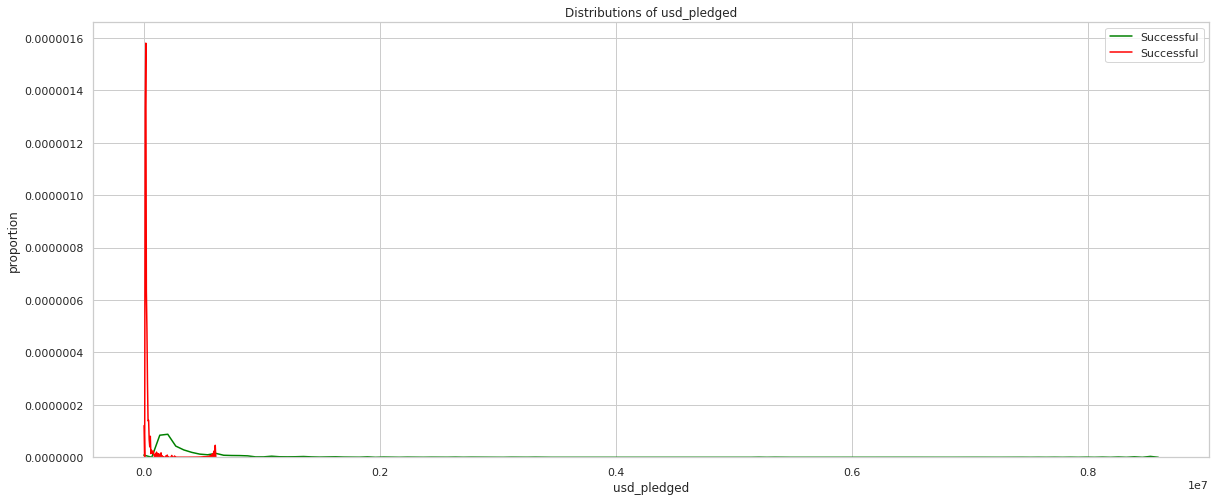

In [79]:
#distribution of usd_pledged
plt.figure(figsize=(20,8))
plt.title('Distributions of usd_pledged')
plt.ylabel('proportion')

sns.distplot(df_successful['usd_pledged'],label='Successful',color='green',hist=False)
sns.distplot(df_failed['usd_pledged'],label='Successful',color='red',hist=False)

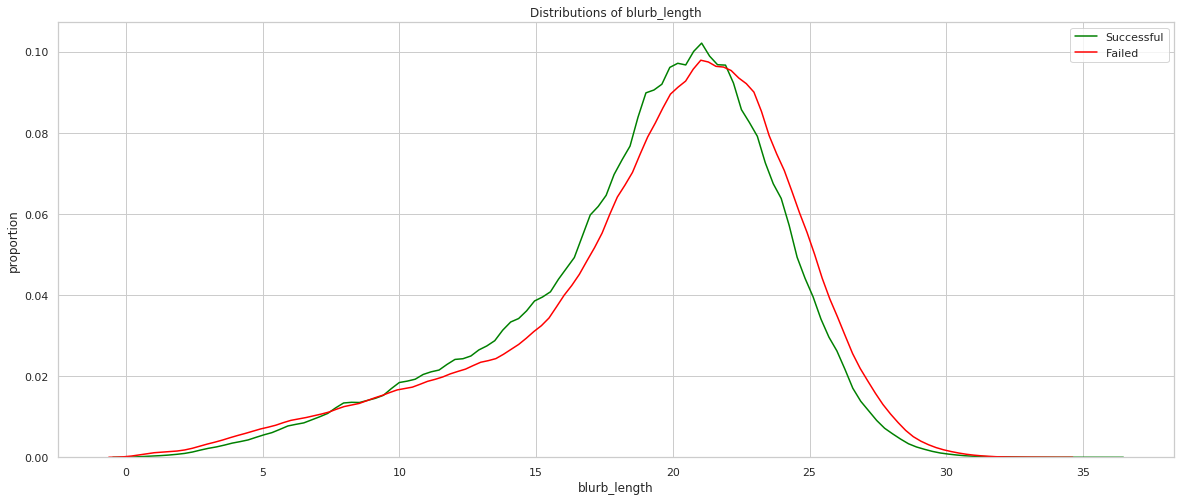

In [80]:
#distribution of blurb_length
plt.figure(figsize=(20,8))
plt.title('Distributions of blurb_length')
plt.ylabel('proportion')

sns.distplot(df_successful['blurb_length'],label='Successful',color='green',hist=False)
sns.distplot(df_failed['blurb_length'],label='Failed',color='red',hist=False)

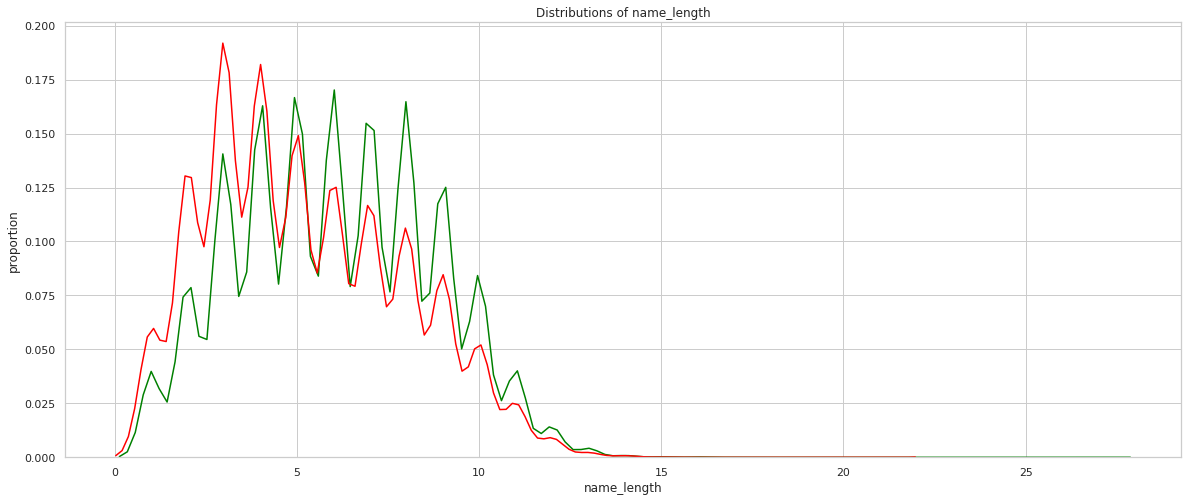

In [81]:
#distribution of name_length
plt.figure(figsize=(20,8))
plt.title('Distributions of name_length')
plt.ylabel('proportion')

sns.distplot(df_successful['name_length'],color='green',hist=False)
sns.distplot(df_failed['name_length'],color='red',hist=False)

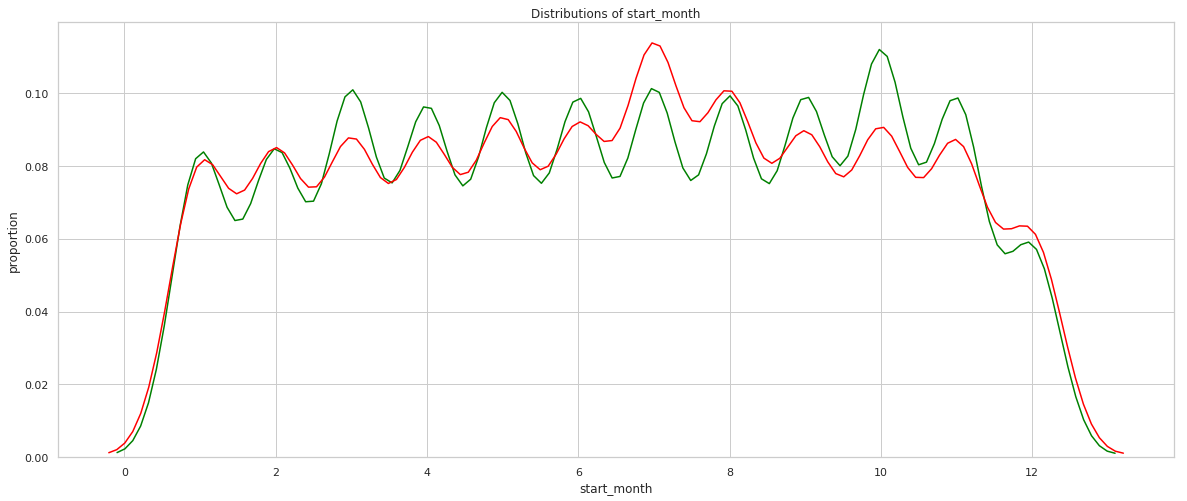

In [82]:
#distribution of star_month
plt.figure(figsize=(20,8))
plt.title('Distributions of start_month')
plt.ylabel('proportion')

sns.distplot(df_successful['start_month'],color='green',hist=False)
sns.distplot(df_failed['start_month'],color='red',hist=False)

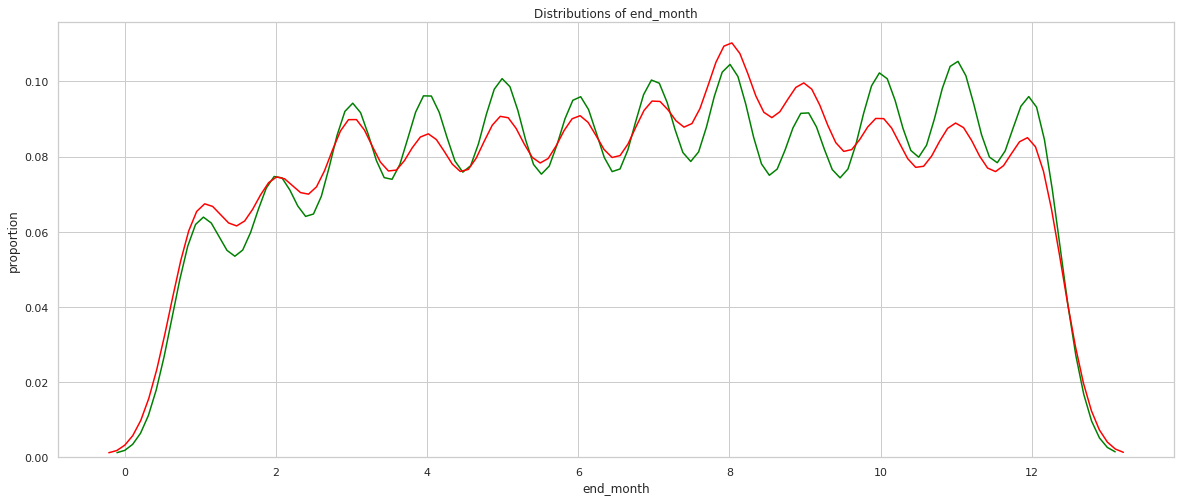

In [83]:
#distribution of end_month
plt.figure(figsize=(20,8))
plt.title('Distributions of end_month')
plt.ylabel('proportion')

sns.distplot(df_successful['end_month'],color='green',hist=False)
sns.distplot(df_failed['end_month'],color='red',hist=False)

Upon these initial visualization of data, we can see that comics, dance, and music seem to have the highest success rates while food, journalism, and technology seem to not do that well. When we compare the overall number of kickstarters in each category, we can see that dance is the least and music is the most popular category, both being the most successful categories. However, it seems that the amount of kickstarters did not effect the rate of successes and failures in each category. 

For the next part of our analysis, we will try to search for differences between successful/failed kickstarters to help distinguish what attributes the successful starters had that the failed didn't.

check how many unique main categories and sub categories there are：

In [84]:
len(df_kickstarters['sub_category'].unique())

159

In [85]:
len(df_kickstarters['main_category'].unique())

15

We will drop some more columns:
- For data on start/end dates of projects, we agreed that observing trends at the month level is best, so we will drop the more specific dates in "launched_at" and "deadline" columns. In addition, some of the columns have redundancy with regards to project funding start and end date. Start and end month is the most balanced.
- The names of the Kickstarters are difficult to quantify and analyze sentiment with nltk as they often contain catchy phrases or made-up words to try to catch consumers' attention, so we will drop the "name" column as well.
- Finally, as shown above, there are 159 sub categories which is a bit excessive to analyze; but there are only 15 main categories which is good for analysis（And also our hypothesis is on main_category）. So we will drop the sub categories.

In [86]:
df_kickstarters.drop(columns=['launched_at', 'deadline', 'name', 'sub_category'], inplace=True)

Next, we will create a function that will change our status (successful, failed) column into binary variables, with 1.0 being successful and 0.0 being failed. We believe that doing this will make data analysis a little faster.

In [87]:
def convert_status(label):
    if label == "successful":
        return float(1.0)
    else:
        return float(0.0)

In [88]:
df_kickstarters['status'] = df_kickstarters['status'].apply(convert_status)

In [89]:
# show final df_kickstarters
df_kickstarters.head()

,main_category,duration,goal_usd,city,state,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged,goal_minus_pledge
0,games,16.0,2000.0,Menasha,WI,14,7,1.0,10,11,Q4,Q4,6061.0,-4061.0
2,fashion,30.0,1100.0,Manhattan,NY,21,7,1.0,6,7,Q2,Q3,1110.0,-10.0
3,music,45.0,3500.0,Nashville,TN,15,6,1.0,9,11,Q3,Q4,4807.0,-1307.0
4,technology,60.0,30000.0,Troy,MI,15,4,1.0,11,1,Q4,Q1,40368.0,-10368.0
5,music,30.0,7500.0,Seattle,WA,11,4,1.0,1,2,Q1,Q1,7770.0,-270.0


Next, we will analyze the means of failed and successful kickstarts for the quantitative variables (duration, goal, blurb length, name length, start and end months, and money pledged) using the groupby function.

In [90]:
#sns.countplot(x='status', data=df_kickstarters, palette='hls')
#plt.show()
#plt.savefig('count_plot')
df_grouped = df_kickstarters.groupby('status').mean()
df_grouped

,duration,goal_usd,blurb_length,name_length,start_month,end_month,usd_pledged,goal_minus_pledge
status,,,,,,,,
0.0,34.601601,81020.575093,19.247716,5.252334,6.442516,6.715932,1061.582359,79958.992734
1.0,30.845921,9380.515233,18.849873,6.073439,6.470154,6.804175,22060.336532,-12679.821299


From this we get some key observations:
- We see clearly that the goals of failed kickstarters were set exponentially higher than their successful counterparts.

- There isn't any discerinble difference between start and end times, and blurb length.

- Successful kickstarters had shorter durations

- Obviously the successful kickstarters had a much higher pledge


In [91]:

df_std = df_kickstarters.groupby('status').std()
df_std

,duration,goal_usd,blurb_length,name_length,start_month,end_month,usd_pledged,goal_minus_pledge
status,,,,,,,,
0.0,12.701759,1.659378e+06,5.204079,2.666351,3.306609,3.328290,5577.869893,1.659339e+06
1.0,10.607315,2.811928e+04,4.883005,2.640535,3.308368,3.336141,120522.291961,1.071039e+05


Let's take a further look into the differences in goal_usd between successful and failed

Text(0.5, 0, 'Status')

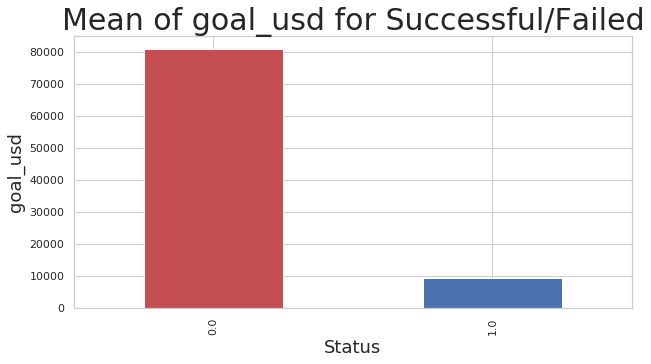

In [92]:
#df.groupby('main_category').mean()
#pd.crosstab(df.start_month, df.status).plot(kind='bar', figsize=(15,5))
#pd.crosstab(df.end_month, df.status).plot(kind='bar', figsize=(15,5))
#pd.crosstab(df.status, df.start_month).plot(kind='bar', figsize=(15,5))
#pd.crosstab(df.start_Q, df.status).plot(kind='bar', figsize=(15, 5))
#pd.crosstab(df.end_Q, df.status).plot(kind='bar', figsize=(15, 5))

my_colors = list(['r', 'b'])
df_grouped.goal_usd.plot.bar(stacked=True, color=my_colors, figsize=(10,5))
plt.title('Mean of goal_usd for Successful/Failed', fontsize=30)
plt.ylabel('goal_usd', fontsize=18)
plt.xlabel('Status', fontsize=18)

In [93]:
fail = df_grouped.loc[0, 'goal_usd']
success = df_grouped.loc[1, 'goal_usd']
percent = ((fail - success) / success) * 100

print("Compared to the successful kickstarters, the failed kickstarters had an increase of " 
      "{0:.2f}".format(percent) + "%\nin there USD goal amount")

Compared to the successful kickstarters, the failed kickstarters had an increase of 763.71%
in there USD goal amount


As we can see, a 736.38% increase in goal_usd for the failed kickstarters is a huge difference compared to the successful kickstarters.

This clearly shows that part of what makes a successful kickstarter is likely setting a realistic goal for funding.  If people who are looking into kickstarters notice that you've set your goal for funding unreasonably high especially with respect to the details of your project, why would they waste time and effort into funding your kickstarter if they know your funding goal likely won't be met?  Perhaps it can also be an indicator that shows that you are naive to the business side of things, which can be seen as a red flag.

In [94]:
df_success = df_kickstarters[df_kickstarters['status'] == 1 ]
df_fail = df_kickstarters[df_kickstarters['status'] == 0 ]

                  #len(df.goal_usd.unique())

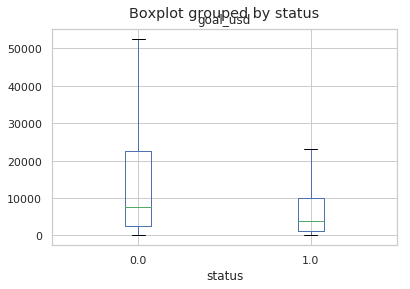

In [95]:
df_kickstarters.boxplot(column=['goal_usd'],by='status',showfliers=False)

It seems that the distributions are too nonnormal for statistical tests to work effectively. So instead, we decided to group the data by state and take the mean of the data by state to be analyzed.

In [96]:
## Get statistical data from each state
state_describe = df_kickstarters.groupby('state').describe()
state_describe

blurb_length                                                      \
             count       mean       std  min    25%   50%    75%   max   
state                                                                    
AK           390.0  18.507692  4.900416  4.0  16.00  19.0  22.00  31.0   
AL           867.0  19.269896  5.365492  3.0  17.00  20.0  23.00  31.0   
AR           525.0  19.047619  5.589625  1.0  17.00  20.0  23.00  29.0   
AZ          2461.0  19.145469  5.075924  1.0  16.00  20.0  23.00  30.0   
CA         24826.0  18.967091  4.956358  1.0  16.00  20.0  22.00  31.0   
CO          3188.0  19.141154  4.785007  3.0  17.00  20.0  22.00  30.0   
CT          1178.0  19.162988  4.977665  1.0  17.00  20.0  23.00  31.0   
DE           290.0  19.093103  4.786980  3.0  16.00  20.0  22.00  30.0   
FL          6325.0  19.010435  5.291612  1.0  17.00  20.0  23.00  33.0   
GA          3449.0  19.140910  5.304791  1.0  17.00  20.0  23.00  33.0   
HI           593.0  19.175379  4.838570  3.0  17.00  20.0  22.00  29.0   
IA           689.0  19.174165  4.817166  3.0  17.00  20.0  23.00  30.0   
ID           671.0  18.891207  4.988802  1.0  16.00  20.0  22.00  29.0   
IL          5164.0  18.841402  4.959435  1.0  16.00  20.0  22.00  32.0   
IN          1553.0  19.007083  5.103120  2.0  16.00  20.0  23.00  30.0   
KS           614.0  19.141694  5.006142  1.0  17.00  20.0  23.00  30.0   
KY           989.0  18.952477  5.221682  2.0  16.00  20.0  23.00  31.0   
LA          1163.0  19.361995  4.981083  1.0  17.00  20.0  23.00  30.0   
MA          3869.0  18.795296  4.861629  1.0  16.00  20.0  22.00  30.0   
MD          1902.0  19.241851  4.729770  1.0  17.00  20.0  23.00  32.0   
ME           701.0  19.269615  4.861811  1.0  17.00  20.0  23.00  30.0   
MI          3048.0  19.054790  5.119954  1.0  16.00  20.0  23.00  32.0   
MN          2567.0  19.273471  4.571508  3.0  17.00  20.0  22.00  33.0   
MO          2022.0  19.216617  5.136779  1.0  17.00  20.0  23.00  30.0   
MS           359.0  19.181058  5.215799  1.0  16.00  20.0  23.00  28.0   
MT           497.0  18.989940  4.860752  3.0  16.00  20.0  22.00  31.0   
NC          3032.0  19.209103  5.100036  1.0  17.00  20.0  23.00  34.0   
ND           153.0  18.699346  5.355869  4.0  16.00  20.0  22.00  29.0   
NE           418.0  18.576555  5.574877  3.0  16.00  20.0  22.00  30.0   
NH           580.0  19.179310  4.564516  3.0  16.75  20.0  22.25  30.0   
NJ          2134.0  18.989222  5.130859  2.0  16.00  20.0  23.00  29.0   
NM           783.0  19.035760  5.012644  3.0  17.00  20.0  22.00  30.0   
NV          1828.0  19.430525  4.646577  3.0  17.00  20.0  23.00  30.0   
NY         15838.0  18.944437  4.885577  1.0  17.00  20.0  22.00  32.0   
OH          3462.0  19.088677  5.166675  1.0  16.00  20.0  23.00  35.0   
OK           902.0  18.941242  5.273632  1.0  16.00  20.0  23.00  31.0   
OR          3468.0  18.839389  4.998054  2.0  16.00  20.0  22.00  29.0   
PA          4324.0  19.002313  4.912229  1.0  17.00  20.0  22.00  31.0   
RI           493.0  19.318458  4.907478  2.0  17.00  20.0  23.00  29.0   
SC          1072.0  18.798507  5.314434  2.0  16.00  20.0  23.00  30.0   
SD           169.0  18.508876  5.225986  2.0  15.00  20.0  22.00  31.0   
TN          2647.0  19.178315  5.318284  1.0  16.00  20.0  23.00  32.0   
TX          7780.0  18.936504  5.176790  1.0  16.00  20.0  23.00  32.0   
UT          2248.0  18.750890  5.064185  1.0  16.00  20.0  22.00  31.0   
VA          2602.0  19.029593  5.012661  1.0  16.00  20.0  23.00  31.0   
VT           592.0  18.986486  4.876459  1.0  16.00  20.0  22.00  29.0   
WA          4557.0  18.768269  4.899412  1.0  16.00  20.0  22.00  31.0   
WI          1745.0  18.966189  5.060245  2.0  16.00  20.0  23.00  30.0   
WV           306.0  19.281046  5.205870  3.0  17.00  20.0  23.00  31.0   
WY           163.0  18.883436  4.468536  1.0  17.00  20.0  22.00  26.0   

      duration                ...     status      usd_pledged                \
    

In [97]:
state_describe_succ = df_successful.groupby('state').describe()
state_describe_succ

blurb_length                                                      \
             count       mean       std  min    25%   50%    75%   max   
state                                                                    
AK           247.0  18.283401  4.724165  7.0  15.00  19.0  22.00  28.0   
AL           451.0  18.771619  5.491302  3.0  15.00  20.0  23.00  29.0   
AR           244.0  19.057377  5.208886  2.0  17.00  20.0  22.00  28.0   
AZ          1314.0  18.928463  4.960873  3.0  16.00  20.0  22.00  30.0   
CA         16457.0  18.814061  4.844413  1.0  16.00  20.0  22.00  31.0   
CO          1924.0  19.029106  4.801974  3.0  16.75  20.0  22.00  29.0   
CT           723.0  18.928077  4.914259  3.0  16.00  20.0  22.00  31.0   
DE           163.0  18.846626  4.662144  3.0  16.00  20.0  22.00  29.0   
FL          2787.0  19.011123  5.001244  2.0  17.00  20.0  22.00  32.0   
GA          1671.0  19.047277  5.124280  1.0  16.00  20.0  23.00  33.0   
HI           326.0  18.880368  4.776975  3.0  16.00  20.0  22.00  29.0   
IA           394.0  18.850254  4.681229  3.0  17.00  20.0  22.00  29.0   
ID           383.0  18.686684  5.078546  1.0  16.00  20.0  22.00  28.0   
IL          3300.0  18.650909  4.870678  2.0  16.00  19.0  22.00  32.0   
IN           788.0  18.836294  5.100001  3.0  16.00  20.0  23.00  29.0   
KS           292.0  18.996575  4.968283  4.0  16.00  20.0  22.25  29.0   
KY           528.0  18.604167  5.185784  2.0  15.00  20.0  23.00  28.0   
LA           676.0  19.386095  4.585037  1.0  17.00  20.0  23.00  29.0   
MA          2814.0  18.681237  4.771832  3.0  16.00  20.0  22.00  30.0   
MD          1100.0  19.113636  4.456115  3.0  17.00  20.0  22.00  31.0   
ME           454.0  18.993392  4.742132  3.0  17.00  20.0  22.00  29.0   
MI          1786.0  18.913214  4.992069  2.0  16.00  20.0  22.00  32.0   
MN          1768.0  19.124434  4.572786  4.0  17.00  20.0  22.00  30.0   
MO          1147.0  18.891892  4.983795  1.0  17.00  20.0  22.00  30.0   
MS           172.0  19.284884  4.588978  6.0  16.00  20.0  23.00  28.0   
MT           329.0  18.920973  4.715680  4.0  16.00  20.0  22.00  31.0   
NC          1648.0  19.100728  4.899678  2.0  17.00  20.0  22.00  34.0   
ND            86.0  18.267442  5.058306  7.0  15.00  20.0  22.00  29.0   
NE           207.0  18.294686  5.755126  3.0  15.00  20.0  22.00  28.0   
NH           356.0  18.629213  4.629074  3.0  16.00  19.0  22.00  29.0   
NJ          1162.0  18.810671  5.114566  2.0  16.00  20.0  22.00  29.0   
NM           458.0  19.248908  4.667412  4.0  17.00  20.0  23.00  30.0   
NV          1082.0  19.408503  4.363824  5.0  17.00  20.0  22.00  30.0   
NY         11402.0  18.876425  4.747117  1.0  16.00  20.0  22.00  32.0   
OH          1863.0  18.854536  4.991915  1.0  16.00  20.0  22.00  35.0   
OK           468.0  18.523504  5.157631  4.0  16.00  20.0  22.00  31.0   
OR          2420.0  18.864050  4.886655  2.0  16.00  20.0  22.00  29.0   
PA          2728.0  18.940982  4.700471  1.0  17.00  20.0  22.00  30.0   
RI           334.0  19.314371  4.729941  5.0  17.00  20.0  22.00  28.0   
SC           581.0  18.211704  5.324789  2.0  15.00  19.0  22.00  28.0   
SD            81.0  18.407407  4.705788  7.0  15.00  20.0  22.00  27.0   
TN          1700.0  19.184118  5.360757  1.0  16.00  20.0  23.00  32.0   
TX          4356.0  18.588843  5.130683  1.0  16.00  20.0  22.00  32.0   
UT          1423.0  18.486297  4.994053  3.0  15.00  19.0  22.00  30.0   
VA          1441.0  18.887578  4.936105  2.0  16.00  20.0  23.00  30.0   
VT           456.0  19.089912  4.627988  1.0  17.00  20.0  22.00  29.0   
WA          3161.0  18.558368  4.871237  1.0  16.00  20.0  22.00  31.0   
WI          1052.0  18.829848  4.984900  2.0  16.00  20.0  22.00  29.0   
WV           161.0  18.850932  5.140782  3.0  17.00  20.0  22.00  28.0   
WY           101.0  18.970297  4.302221  1.0  17.00  20.0  22.00  25.0   

      duration                ...     start_month       usd_pledged  \
         cou

In [98]:
state_describe_fail = df_failed.groupby('state').describe()
state_describe_fail

blurb_length                                                     \
             count       mean       std  min    25%   50%   75%   max   
state                                                                   
AK           143.0  18.895105  5.184909  4.0  16.00  20.0  22.0  31.0   
AL           416.0  19.810096  5.178267  4.0  17.00  21.0  23.0  31.0   
AR           281.0  19.039146  5.909608  1.0  16.00  21.0  23.0  29.0   
AZ          1147.0  19.394071  5.195638  1.0  17.00  21.0  23.0  30.0   
CA          8369.0  19.268013  5.156488  1.0  17.00  20.0  23.0  31.0   
CO          1264.0  19.311709  4.755893  3.0  17.00  20.0  23.0  30.0   
CT           455.0  19.536264  5.059808  1.0  17.00  21.0  23.0  30.0   
DE           127.0  19.409449  4.943096  6.0  17.00  21.0  23.0  30.0   
FL          3538.0  19.009893  5.510282  1.0  17.00  20.0  23.0  33.0   
GA          1778.0  19.228909  5.468991  1.0  17.00  20.0  23.0  32.0   
HI           267.0  19.535581  4.897603  5.0  18.00  21.0  23.0  28.0   
IA           295.0  19.606780  4.968057  5.0  17.00  20.0  23.0  30.0   
ID           288.0  19.163194  4.862331  3.0  17.00  20.0  22.0  29.0   
IL          1864.0  19.178648  5.096677  1.0  17.00  20.0  23.0  30.0   
IN           765.0  19.183007  5.103687  2.0  17.00  20.0  23.0  30.0   
KS           322.0  19.273292  5.044336  1.0  17.00  20.0  23.0  30.0   
KY           461.0  19.351410  5.239705  3.0  16.00  20.0  23.0  31.0   
LA           487.0  19.328542  5.488378  2.0  17.00  20.0  23.0  30.0   
MA          1055.0  19.099526  5.083230  1.0  16.00  20.0  23.0  29.0   
MD           802.0  19.417706  5.078789  1.0  17.00  21.0  23.0  32.0   
ME           247.0  19.777328  5.044821  1.0  18.00  21.0  23.0  30.0   
MI          1262.0  19.255151  5.291191  1.0  17.00  20.0  23.0  30.0   
MN           799.0  19.603254  4.554217  3.0  17.00  20.0  23.0  33.0   
MO           875.0  19.642286  5.303493  1.0  17.00  21.0  23.0  30.0   
MS           187.0  19.085561  5.742986  1.0  16.00  21.0  23.0  28.0   
MT           168.0  19.125000  5.144833  3.0  17.00  20.0  23.0  28.0   
NC          1384.0  19.338150  5.327709  1.0  17.00  20.0  23.0  32.0   
ND            67.0  19.253731  5.705774  4.0  17.00  21.0  23.0  28.0   
NE           211.0  18.853081  5.391548  4.0  16.00  20.0  23.0  30.0   
NH           224.0  20.053571  4.328111  7.0  18.00  21.0  23.0  30.0   
NJ           972.0  19.202675  5.144771  2.0  17.00  20.0  23.0  29.0   
NM           325.0  18.735385  5.455556  3.0  16.00  20.0  22.0  29.0   
NV           746.0  19.462466  5.031371  3.0  17.00  20.0  23.0  29.0   
NY          4436.0  19.119252  5.221150  1.0  17.00  20.0  23.0  31.0   
OH          1599.0  19.361476  5.351772  2.0  17.00  20.0  23.0  30.0   
OK           434.0  19.391705  5.365489  1.0  17.00  20.5  23.0  30.0   
OR          1048.0  18.782443  5.248222  3.0  16.00  20.0  23.0  29.0   
PA          1596.0  19.107143  5.254327  1.0  17.00  20.0  23.0  31.0   
RI           159.0  19.327044  5.276527  2.0  17.00  21.0  23.0  29.0   
SC           491.0  19.492872  5.222933  2.0  17.00  21.0  23.0  30.0   
SD            88.0  18.602273  5.688342  2.0  15.00  19.0  22.0  31.0   
TN           947.0  19.167899  5.243974  1.0  17.00  20.0  23.0  30.0   
TX          3424.0  19.378797  5.202128  1.0  17.00  20.0  23.0  31.0   
UT           825.0  19.207273  5.154124  1.0  17.00  20.0  23.0  31.0   
VA          1161.0  19.205857  5.102721  1.0  17.00  20.0  23.0  31.0   
VT           136.0  18.639706  5.635434  4.0  15.75  20.0  23.0  28.0   
WA          1396.0  19.243553  4.931443  2.0  17.00  20.0  23.0  30.0   
WI           693.0  19.173160  5.169276  4.0  17.00  20.0  23.0  30.0   
WV           145.0  19.758621  5.253670  4.0  17.00  20.0  23.0  31.0   
WY            62.0  18.741935  4.759582  2.0  16.00  19.5  22.0  26.0   

      duration               ...     start_month       usd_pledged  \
         count       mean    ...             75%   max       count

We will now create plots of the mean durations, grouped by state.

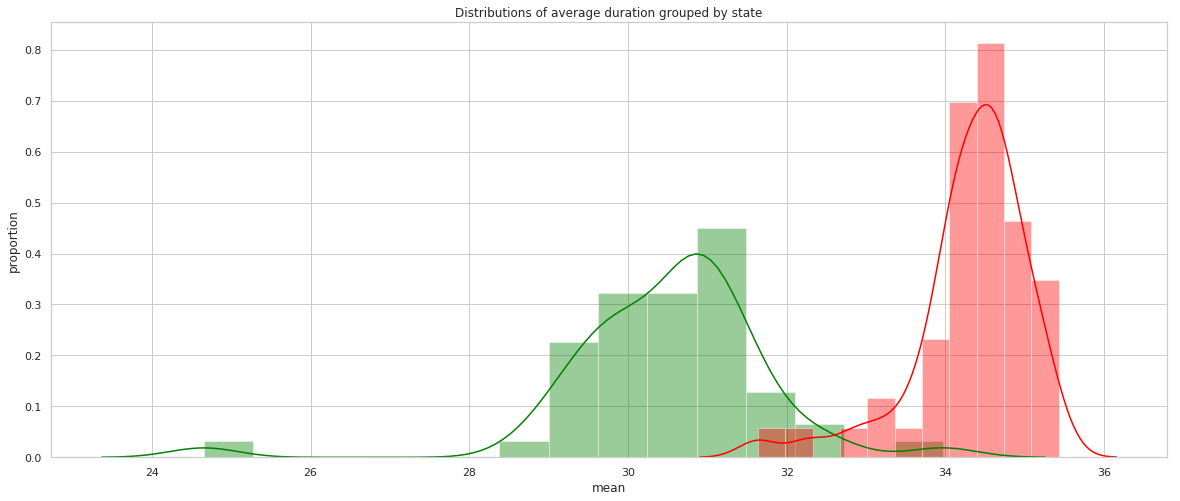

In [99]:
plt.figure(figsize=(20,8))
plt.title('Distributions of average duration grouped by state')
plt.ylabel('proportion')

sns.distplot(state_describe_succ['duration']['mean'],color='green')
sns.distplot(state_describe_fail['duration']['mean'],color='red')

Visually, there appears to be a significant difference in distributions; we will use a t-test to confirm.

In [100]:
stats.ttest_ind(state_describe_succ['duration']['mean'],state_describe_fail['duration']['mean'])

Ttest_indResult(statistic=-18.101157995571793, pvalue=5.0951022801304901e-33)

The p-value is much less than alpha value of 0.05; we can thus see that durations of Kickstarters is an important determinant, with failed kickstarters usually taking longer.

Next we will compare the distributions of the average start and end months grouped by state.

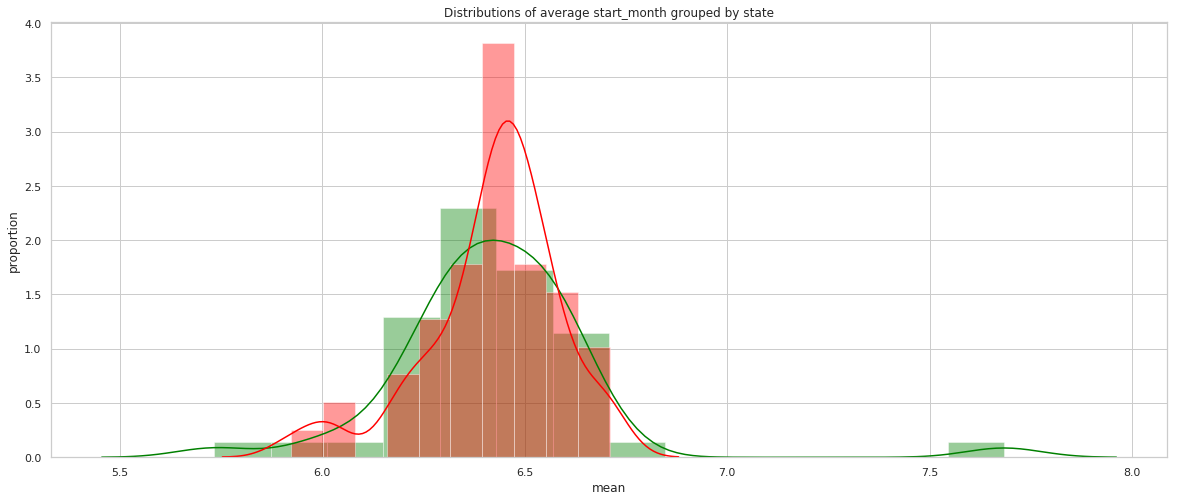

In [101]:
plt.figure(figsize=(20,8))
plt.title('Distributions of average start_month grouped by state')
plt.ylabel('proportion')

sns.distplot(state_describe_succ['start_month']['mean'],color='green')
sns.distplot(state_describe_fail['start_month']['mean'],color='red')

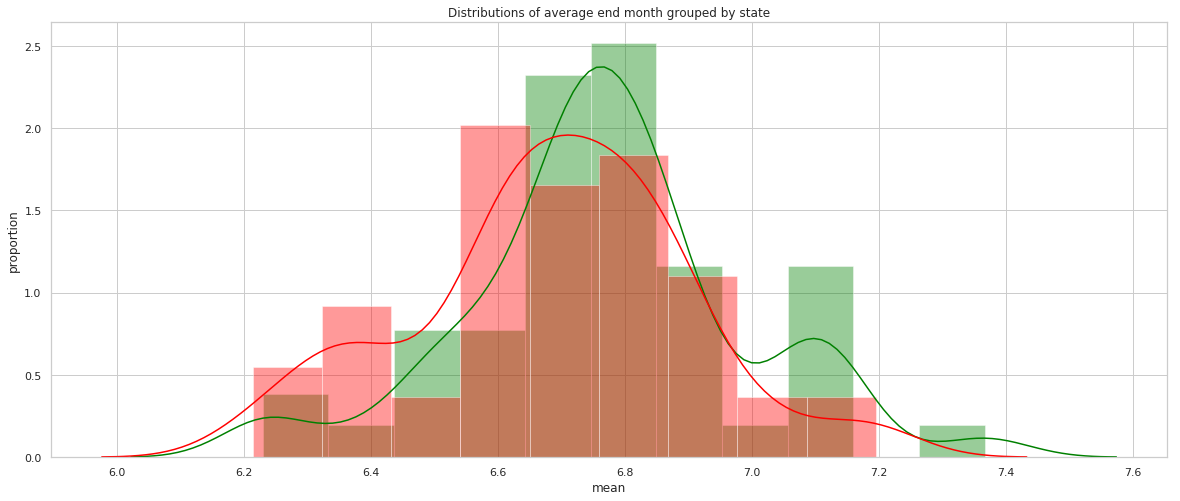

In [102]:
plt.figure(figsize=(20,8))
plt.title('Distributions of average end month grouped by state')
plt.ylabel('proportion')

sns.distplot(state_describe_succ['end_month']['mean'],color='green')
sns.distplot(state_describe_fail['end_month']['mean'],color='red')

There doesn't seem to be much visual difference in these distributions; we ran t-tests to corroborate our visual conclusions.

In [103]:
stats.ttest_ind(state_describe_succ['start_month']['mean'],state_describe_fail['start_month']['mean'])

Ttest_indResult(statistic=0.11668212708718963, pvalue=0.9073507397613596)

In [104]:
stats.ttest_ind(state_describe_succ['end_month']['mean'],state_describe_fail['end_month']['mean'])

Ttest_indResult(statistic=1.9461683961465335, pvalue=0.054498627331500078)

Indeed, the t-test of distributions of average start and end months grouped by state did not output p-values less than 0.05 and thus the start and end months of Kickstarters don't seem to affect status significantly.

AttributeError: 'str' object has no attribute 'conjugate'

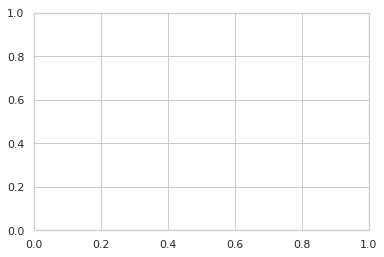

In [111]:

sns.residplot(df_kickstarters['main_category'].values, df_kickstarters['status'].values, lowess=True, scatter_kws={"color":"black","alpha":0.7,"s":70})

In [116]:
r, p = stats.pearsonr(df_kickstarters['main_category'],df_kickstarters['status'])
print('Pearson\'s Correlation coefficient:', r)
print("{0:.2f}".format((r**2)*100))
print(' % of the variability in income can be accounted to hospitalization rate.')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Lastly, we will test which states Kickstarters are most likely to achieve success in.

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Count of numbers of Kickstarters per state')
plt.ylabel('proportion')

ax_state = sns.countplot(x='state',hue='status',data=df_kickstarters)

And a plot of proportions:

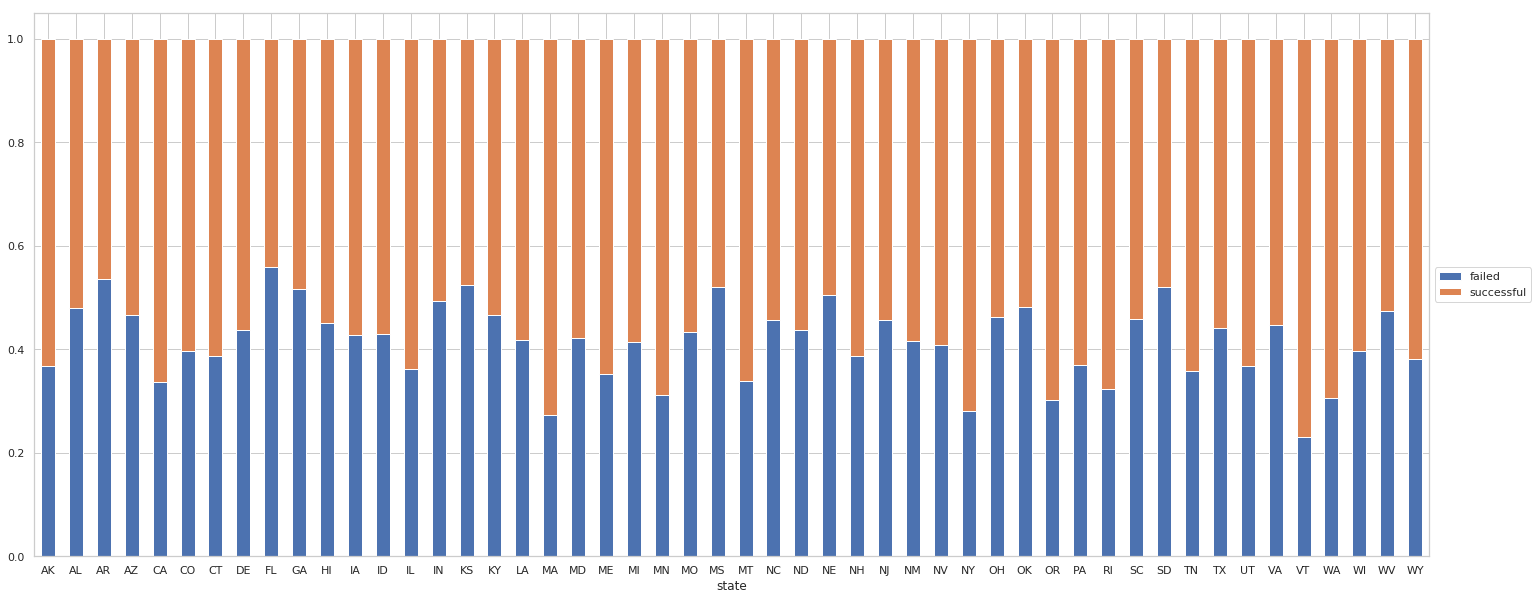

In [112]:
df_state = df_kickstarters.groupby(['status','state'])['status'].count().unstack('state').fillna(0)
sub_df_state = np.transpose(df_state.div(df_state.sum()))
sub_df_state.plot(kind='bar',stacked=True,rot=0, figsize=(25,10))

plt.legend(('failed','successful'), loc='center left', bbox_to_anchor=(1.0, 0.5))

So it seems that the most successful Kickstarter projects come from VT, which is Vermont, MA, Massachussetts, and NY, New York.

# Ethics & Privacy

We must decide if Kickstarter and crowdfunding should only be used to fund a project’s minimum requirements or whether these “above and beyond” moments of success should be allowed and celebrated, and we must also decide if Kickstarter’s essential nature is to allow unestablished artists and creators to find success or if people like Braff should be allowed  to use the service despite their previous success.

Unique from other creators, Kickstarter creators have a preexisting obligation to their consumers to deliver a certain amount of quality, because many of their consumers will have already paid money and will have a certain expectation for what will be delivered. Does the artist’s vision suffer when they are encouraged to meet a certain expectation? If so, is it okay if their vision is changed to please  their backers, who funded the actual creation? Crowdsourcing offers an interesting dilemma, and begs the question: is the essential nature of creation to please consumers even if some artistic vision is lost, or is it to allow the artist absolute freedom in their creation?

Considering using this dataset which is showing the results from each kickstarter projects, then it could be another ethical problem that we are using their information. Although this dataset does not consist of any information regarding to neither personal nor confidential, there is a way to track which project was successful by looking and analyzing all the information here; it could be a risk of revealing personal information as well.

# Conclusion & Discussion

Which category/subcategory is the most successful/ the least according to the funding success result?
“music”,”film & video”, and “publishing” have the most common for kickstarter projects’ main categories. Although these main categories are quite common, it does not mean that they have the highest rates of getting better successful rates. From the ratio chart, we found out that the most successful main categories were “dance”, “comics”, and “publishing”. 

Also, the plot graphing showed that the successful projects tend to have shorter  duration than failed ones, and the reasons we considered were because they analyzed their duration which their goals can be accomplished by the end of the duration they set, Also, it is showing that failed projects’ durations are distributed wider than the successful, therefore, we concluded that the most successful duration must be between about 28 and 32 days, according to the graph and our analysis